# 1. Практическое задание. Обучение полносвязной нейронной сети.

**ФИО**: Коротаев Павел Дмитриевич

**Дедлайн**: 09 октября 2020

In [3]:
import numpy as np
import torch
import cv2

from glob import glob
from collections import OrderedDict
from matplotlib import pyplot as plt

from torch import nn
from torch.autograd import Function
from torch.autograd import gradcheck
from torch.optim import Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms

## 1. Загрузка данных

Если вам требуется работать с каким-нибубь набором данных (dataset), то прежде всего проверьте нет ли его среди встроенных наборов данных https://pytorch.org/vision/stable/datasets.html.

В текущем домашнем задании мы будем работать с набором данных FashionMNIST. Он присутствует в списке встроенных наборов данных, однако мы воспользуемся реализацией только для удобного и быстрого способа скачать наборы данных. Ниже предлагается реализовать собственный класс для считывания, обработки и упаковки данных.

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Воспользуемся функцией загрузки данных из репозитория наборов данных.

In [4]:
! ls data/FashionMNIST/raw

t10k-images-idx3-ubyte	   train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte	   train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [5]:
#https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

Для удобства PyTorch предоставляет ряд базовых классов `Dataset, DataLoader`, от которых предлагается отнаследоваться при разработке пользовательских классов. Базовый класс `Dataset` используется для загрузки и обработки данных, класс `DataLoader` используется для управления процессом загрузки данных, позволяет в многопоточном режиме загружать данные и упаковывать их.
Эти вспомогательные классы находятся в модуле `torch.utils.data`. 

При наследовании от класса `torch.utils.data.Dataset` требуется переопределить метод `__len__`, который возвращает количество примеров в наборе данных, а также метод `__getitem__`, который позволяет получить доступ к примеру из набора данных по индексу.

Реализуем класс для FasionMnist.

Элементами датасета должны являться пары '(np.array, int)', массив имеет размерность `(28, 28)`, тип элемента `np.float32`.

In [6]:
import os

class FashionMnist(Dataset):
    def __init__(self, path, train=True, image_transform=None, 
                 label_transform=None):
        if train:
            images, labels = load_mnist(os.path.join(path,"raw"))
        else:
            images, labels = load_mnist(os.path.join(path,"raw"), kind="t10k")
        
#         plt.imshow(images)
        self.images = images
        self.labels = labels
        self.image_transform = image_transform

    def __len__(self,):
        return len(self.labels)

    def __getitem__(self, idx):
        
        img = self.images[idx].reshape(28,-1).copy()
        label = self.labels[idx]
        
        if self.image_transform is not None:
            img = self.image_transform(img)
            
        return img, label


In [7]:
test_dataset = FashionMnist("data/FashionMNIST", train=False)
train_dataset = FashionMnist("data/FashionMNIST")

Визуализируйте случайные элементы набора данных.

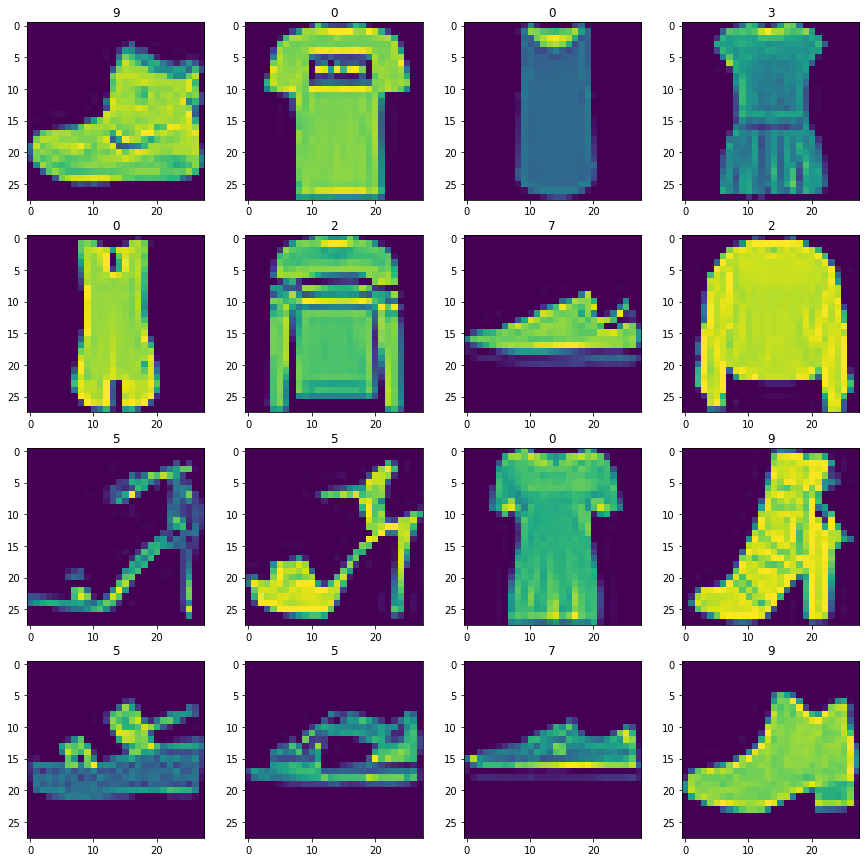

In [8]:
fig, axs = plt.subplots(4, 4)
fig.set_figheight(15)
fig.set_figwidth(15)

row = -1
for idx, data in enumerate(train_dataset):
    img, label = data
    if idx == 16:
        break
    col = idx % 4
    if col == 0:
        row+=1
    axs[row][col].imshow(img)
    axs[row][col].title.set_text(str(label))


В конструктор `Dataset` можно передать объект `torchvision.transforms`, который позволяет преобразовать исходные данные. Преобразование `torchvision.transforms.ToTensor` позволяет преобразоать данные из типа `PIL Image` и `numpy.float32` в тип `torch.float32`

Реализуйте собственную поддержку преобразований в `FashionMnist`. Проверьте, что приведение типов работает корректно. 

In [9]:
class ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        return torch.from_numpy(sample)

In [10]:
transform = ToTensor()

test_dataset = FashionMnist("data/FashionMNIST", 
                            train=False, 
                            image_transform=transform, 
                            label_transform=transform
                            )
train_dataset = FashionMnist("data/FashionMNIST",
                             image_transform=transform, 
                             label_transform=transform
                             )

In [11]:
print(f"The type of the data is {type(test_dataset[0][0])}")

The type of the data is <class 'torch.Tensor'>


Элементы набора данных могут быть объединены в пакеты (batch) явно и неявно. Если данные могут быть сконкатенированы или обЪединены каким-нибудь тривиальным способом, то можно не передавать никаких дополнительных парамертов в `torch.utils.data.Dataloader`.

In [12]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2, shuffle=True)
batch = next(iter(test_dataloader))

In [13]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 28, 28])


Однако, если наша структура данных не позволяет нам использовать объединение по умолчанию, то можно написать собственную функцию, которая будет пакетировать данные. 

Реализуйте функцию, преобразующую последовательность элементов массива в пакет (batch).

In [14]:
def collate(batch):

    imgs = []
    labels = []
    for i in range(len(batch)):
        imgs.append(batch[i][0].view(28*28))
        labels.append(int(batch[i][1]))
 
    imgs = torch.stack(imgs)
    imgs = imgs.to(torch.float64)
    labels = torch.tensor(labels)  
    return imgs, labels

Убедитесть, что все работает корректно. 

In [15]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2, 
                             shuffle=True, collate_fn=collate)
train_dataloader = DataLoader(train_dataset, batch_size=15, num_workers=2,
                              shuffle=True, collate_fn=collate)
batch = next(iter(test_dataloader))

In [16]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")
print(batch[0])

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 784])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)


## 2. Реализация модулей нейронной сети (15 баллов)

В этом разделе мы полностью реализуем модули для полносвязанной сети. 

Для начала нам понадобится реализовать прямой и обратный проход через слои. 

Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):

Сначала, мы реализуем функцию и её градиент. 

In [17]:
class IdentityFunction(Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        return input

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        return grad_output

Разработанную функцию обернем классом `IdentityLayer`, все слои в `PyTorch` должны быть наследниками базового класса `nn.Module()`


In [18]:
class IdentityLayer(nn.Module):
    def __init__(self):
        # An identity layer does nothing
        super().__init__()
        self.identity = IdentityFunction.apply
    
    def forward(self, inp):
        # An identity layer just returns whatever it gets as input.
        return self.identity(inp)


### 2.1 Функция активации ReLU
Для начала реализуем функцию активации, слой нелинейности `ReLU(x) = max(x, 0)`. Параметров у слоя нет. Метод `forward` должен вернуть результат поэлементного применения `ReLU` к входному массиву, метод `backward` - градиент функции потерь по входу слоя. В нуле будем считать производную равной 0. Обратите внимание, что при обратном проходе могут понадобиться величины, посчитанные во время прямого прохода, поэтому их стоит сохранить в `ctx`.

In [19]:
class ReLUFunction(Function):
    @staticmethod
    def forward(ctx, input):
        x = torch.clone(input)
        x[x < 0] = 0
        ctx.save_for_backward(x)
        return x

    @staticmethod
    def backward(ctx, grad_output):
        after_relu = torch.clone(ctx.saved_tensors[0])
        after_relu[after_relu>0]=1
        return after_relu * grad_output

In [20]:
class ReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = ReLUFunction.apply

    def forward(self, input):
        return self.relu(input)

Не забываем после реализации функции проверить градиент, испльзуя функцию `gradcheck`.

In [21]:
x = torch.tensor([[1,2,3],
                 [-1,2, 1]],dtype=torch.double,requires_grad=True)
relu = ReLU()
assert gradcheck(relu, x)

In [22]:
torch_relu = nn.ReLU()
our_relu = ReLU()
x = torch.randn(20,20,dtype=torch.double,requires_grad=True)

assert torch.norm(torch_relu(x.float()) - our_relu(x)) < 1e-5

### 2.2 Линейный слой (linear, fully-connected)
Далее реализуем полносвязный слой без нелинейности. У слоя два набора параметра: матрица весов (weights) и вектор смещения (bias).

In [23]:
from torch.nn.parameter import Parameter

In [24]:
class LinearFunction(Function): #1
    @staticmethod
    def forward(ctx, inp, weight, bias):
        ctx.save_for_backward(inp, weight, bias)
        output = torch.mm(inp, weight.t()) + bias
        return output
    @staticmethod
    def backward(ctx, grad_output):
        inp, weight, bias = ctx.saved_tensors
        grad_weigth = torch.mm(inp.t(), grad_output).t()
        grad_input = torch.mm(grad_output, weight)
        grad_bias = torch.sum(grad_output,0)
        return grad_input, grad_weigth, grad_bias


class Linear(nn.Module):
    def __init__(self, input_units, output_units):
        super().__init__()
        self.weight = Parameter(torch.normal(0, 1, size=(output_units, input_units), dtype=torch.float64, 
                                   requires_grad=True))
        self.bias = Parameter(torch.squeeze(torch.ones((1, output_units), dtype=torch.float64, 
                                 requires_grad=True)))
        
        
    def forward(self, inp):
        self.linear = LinearFunction.apply(inp, self.weight, self.bias)
        return self.linear

Проверим градиент, а также сравним с работой нашего модуля с имплементированным в `PyTorch`. 

Проверка градиента:

In [25]:
x = torch.randn(128, 20, dtype=torch.double,requires_grad=True)
linear = Linear(20,30)

assert gradcheck(linear, x)

Сравнение с `PyTorch`. 

In [26]:
weight = torch.normal(0, 1, size=(16, 8), dtype=torch.double)
bias = torch.ones((1, 16), dtype=torch.double)
torch_linear = nn.Linear(8,16)
our_linear = Linear(8,16)
state_dict = OrderedDict([("weight", weight), ("bias", torch.squeeze(bias))])
# state_dict2 = OrderedDict([("weight", weight.t()), ("bias", torch.squeeze(bias))])

torch_linear.load_state_dict(state_dict)
our_linear.load_state_dict(state_dict)

x = torch.rand((4,8),dtype=torch.double,requires_grad=True)

assert torch.norm(torch_linear(x.float()) - our_linear(x)) < 1e-5

### 2.3 LogSoftmax (Log + Softmax)

Для решения задачи многоклассовой классификации обычно используют `softmax` в качестве нелинейности на последнем слое, чтобы получить "оценку" вероятности классов для каждого объекта:$$\hat y = softmax(x)  = \bigl \{\frac {exp(x_i)}{\sum_j exp(x_j)} \bigr \}_{i=1}^K, \quad K - \text{число классов}$$В этом случае удобно оптимизировать логарифм правдоподобия:$$L(y, \hat y) = -\sum_{i=1}^K y_i \log \hat y_i \rightarrow \min,$$где $y_i=1$, если объект принадлежит $i$-му классу, и 0 иначе. Записанная в таком виде, эта функция потерь совпадает с выражением для кросс-энтропии. Очевидно, что ее также можно переписать через индексацию, если через $y_i$ обозначить класс данного объекта:$$L(y, \hat y) = - \log \hat y_{y_i} \rightarrow \min$$В таком виде ее удобно реализовывать.

Реализуйте слой `LogSoftmax` (без параметров). Метод `forward` должен вычислять логарифм от `softmax`, а метод `backward` - пропускать градиенты. В общем случае в промежуточных вычислениях `backward` получится трехмерный тензор, однако для нашей конкретной функции потерь все вычисления можно реализовать в матричном виде. Поэтому мы будем предполагать, что аргумент `grad_output` - это матрица, у которой в каждой строке только одно ненулевое значение (не обязательно единица).

Комментарий: разобраться `Log-Sum-Exp trick`

In [27]:
class LogSoftmaxFunction(Function):
    @staticmethod
    def forward(ctx, inp):
        vals, _ = torch.max(inp,1)
        vals = torch.unsqueeze(vals,0).t()
        inp = inp - vals 
        num = inp.exp()
        denum = inp.exp().sum(-1, keepdims=True)
        to_return = inp - torch.log(denum)
        to_return2 =  num/denum
        ctx.save_for_backward(to_return2)
        return to_return
    
    @staticmethod        
    def backward(ctx, grad_output):
        soft_y = ctx.saved_tensors[0]
        sum_grad = torch.sum(grad_output, 1)
        sum_grad = sum_grad.view(soft_y.shape[0], 1)
        return grad_output - sum_grad*soft_y


class LogSoftmax(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = LogSoftmaxFunction.apply

    def forward(self, input):
        return self.softmax(input)

Проверка градиентов.

In [28]:
x = torch.tensor([[1,2, 3, 4],
                  [5,3,2,1]],dtype=torch.double,requires_grad=True)
x = torch.tensor([[1,2, 3, 4]],dtype=torch.double,requires_grad=True)
lsf = LogSoftmax()
assert gradcheck(lsf, x)

In [29]:
torch_LogSoftmax = nn.LogSoftmax()
our_LogSoftmax = LogSoftmax()
x = torch.tensor([[1,2, 3, 4],
                  [5,6,17,8],
                 [10, 12, 13, 14]],dtype=torch.double,requires_grad=True)
print(torch_LogSoftmax(x))
print(our_LogSoftmax(x))
# assert torch.norm(torch_LogSoftmax(x) - our_LogSoftmax(x)) < 1e-5


tensor([[-3.4402e+00, -2.4402e+00, -1.4402e+00, -4.4019e-01],
        [-1.2000e+01, -1.1000e+01, -1.4625e-04, -9.0001e+00],
        [-4.4197e+00, -2.4197e+00, -1.4197e+00, -4.1972e-01]],
       dtype=torch.float64, grad_fn=<LogSoftmaxBackward0>)
tensor([[-3.4402e+00, -2.4402e+00, -1.4402e+00, -4.4019e-01],
        [-1.2000e+01, -1.1000e+01, -1.4625e-04, -9.0001e+00],
        [-4.4197e+00, -2.4197e+00, -1.4197e+00, -4.1972e-01]],
       dtype=torch.float64, grad_fn=<LogSoftmaxFunctionBackward>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


### 2.4 Dropout
Реализуйте слой Dropout.

In [30]:
class dropout(Function):
    @staticmethod
    def forward(ctx, inp, p):
        probs = torch.full((1,inp.shape[-1]), p)
        mask = torch.bernoulli(probs)/(1-p)
        mask = mask.cuda()
        ctx.save_for_backward(mask)
        return inp * mask
        
        
    @staticmethod
    def backward(ctx, grad_output):
        mask = torch.clone(ctx.saved_tensors[0])
        return torch.squeeze(grad_output * mask), None

In [31]:
class Dropout(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p
    def forward(self, input):
        self.d = dropout.apply(input, self.p)
        return self.d

### 2.5 CrossEntropy

При решении задачи многоклассовой классификации мы будет использовать в качестве функции потерь кроссэнтропию. Реализуйте функцию потерь. В разделе 2.3 приведены полезные формулы.

In [32]:
import torch.nn.functional as F
class CrossEntropyFunction(Function):
    @staticmethod
    def forward(ctx, activations, target):
        mask = F.one_hot(target, activations.shape[1])
        ctx.save_for_backward(-activations*mask, -mask) 
        return torch.sum(-activations.gather(1, target.unsqueeze(1)))

    @staticmethod
    def backward(ctx, grad_output):
        grad_target, grad_act = ctx.saved_tensors
        
        return grad_output*grad_act, grad_output*grad_target
        

class CrossEntropy(nn.Module):
    def __init__(self, ):
        super().__init__()
        self

    def forward(self, activations, target):
        self.CELoss = CrossEntropyFunction.apply(activations, target)
        return self.CELoss


Проверка градиентов.

In [33]:
x = torch.tensor([[1,2, 3, 4],
                  [4,3,2,1]],dtype=torch.double,requires_grad=True)
our_LogSoftmax = LogSoftmax()
act = our_LogSoftmax(x)
target = torch.tensor([3, 0])
loss = CrossEntropy()
assert gradcheck(loss, (act, target))

## 3. Сборка и обучение нейронной сети (5 балла)

Реализуйте произвольную нейросеть, состоящую из ваших блоков. Она должна состоять из нескольких полносвязанных слоев.

In [34]:
class Network(nn.Module):
    def __init__(self, input_size=28*28, hidden_layers_size=32, num_layers=5,
                 num_classes=10):
        super().__init__()
        self.hid_block = []
        self.fc1 = Linear(28*28, 1024)
        self.relu = ReLU()
        for i in range(num_layers):
            self.hid_block.append(Linear(1024, 1024))
            self.hid_block.append(ReLU())
                                  
        self.hid_block = nn.Sequential(*self.hid_block)
        
        
        self.fc2 = Linear(1024, 512)
        self.relu2 = ReLU()
        self.fc3 = Linear(512, 128)
        self.relu3 = ReLU()
        self.fc4 = Linear(128, 64)
        self.relu5 = ReLU()
        self.fc5 = Linear(64, 10)
        
        self.sf = LogSoftmax()

    def forward(self, inp):
        # inp = inp.to(torch.float32)
        # print(inp)
        x = self.fc1(inp)
        x = self.relu(x)
        x = self.hid_block(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu5(x)
        x = self.fc5(x)
        x = self.sf(x)

        
        return x
        
    def predict(self, inp):

        x = self.fc1(inp)
        x = self.relu(x)

        x = self.hid_block(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu5(x)
        x = self.fc5(x)
        
        _, preds  = torch.max(x.data, 1)
        return preds


In [35]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2, 
                             shuffle=True, collate_fn=collate)
train_dataloader = DataLoader(train_dataset, batch_size=15, num_workers=2,
                              shuffle=True, collate_fn=collate)

Ниже приведены функции, реализующие обучение нейронной сети. В данном задании их предлагается просто переиспользовать. 

In [36]:
class EmptyContext:
    def __enter__(self):
        pass
    
    def __exit__(self, *args):
        pass

In [37]:
# accuract metric for our classififcation
def accuracy(model_labels, labels):
    return torch.mean((model_labels == labels).float())

In [38]:
def perform_epoch(model, loader, criterion, 
                optimizer=None, device=None):
    is_train = optimizer is not None
    model = model.to(device)
    if is_train:  
        model.train()
    else:
        model.eval()

    total_loss = 0
    total_acc = 0
    total_n = 0
    with EmptyContext() if is_train else torch.no_grad():
        for batch_data, batch_labels in loader:
            batch_data = batch_data.to(device)
            # print(batch_data)
            batch_labels = batch_labels.to(device)         
            model_labels = model(batch_data)
            model_prediction = model.predict(batch_data)
            new_loss = criterion(model_labels, batch_labels)
            if is_train:
                optimizer.zero_grad()
                new_loss.backward()
                optimizer.step() 

            one_batch_loss = float(criterion(model_labels, batch_labels))
            one_batch_acc = accuracy(model_prediction, batch_labels)
            
            total_loss += one_batch_loss
            total_acc += one_batch_acc
            total_n += 1 
    return (total_loss / total_n, total_acc / total_n, model) 

Теперь обучим нашу нейронную сеть. В данном разделе будем использовать оптимизатор `Adam` с параметрами по умолчанию.

In [51]:
model = Network()
optimizer = Adam(
    [
    {"params":model.parameters(), "lr":0.001}
    ],
)
criterion = CrossEntropy()


In [ ]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in tqdm(range(10)):
    loss, acc, model = perform_epoch(model, train_dataloader, criterion, 
                                optimizer=optimizer, device=device)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

 10%|█         | 1/10 [01:31<13:43, 91.49s/it]

Epoch - 0 : loss 57685365892139.28, accuracy 0.7337473630905151
Current learning rate: 0.001


 20%|██        | 2/10 [03:02<12:11, 91.42s/it]

Epoch - 1 : loss 4645215950250.578, accuracy 0.7797844409942627
Current learning rate: 0.001


 30%|███       | 3/10 [04:34<10:41, 91.59s/it]

Epoch - 2 : loss 1402059843010.5713, accuracy 0.7806002497673035
Current learning rate: 0.001


 40%|████      | 4/10 [06:06<09:09, 91.65s/it]

Epoch - 3 : loss 467322630582.31476, accuracy 0.7865167856216431
Current learning rate: 0.001


 50%|█████     | 5/10 [07:38<07:39, 91.86s/it]

Epoch - 4 : loss 178961388018.94138, accuracy 0.7829182147979736
Current learning rate: 0.001


 60%|██████    | 6/10 [09:11<06:08, 92.09s/it]

Epoch - 5 : loss 74822905185.98503, accuracy 0.7837515473365784
Current learning rate: 0.001


 70%|███████   | 7/10 [10:44<04:37, 92.38s/it]

Epoch - 6 : loss 35544097781.352554, accuracy 0.7788341045379639
Current learning rate: 0.001


 80%|████████  | 8/10 [12:17<03:05, 92.70s/it]

Epoch - 7 : loss 19877612576.212757, accuracy 0.7740838527679443
Current learning rate: 0.001


 90%|█████████ | 9/10 [13:51<01:33, 93.02s/it]

Epoch - 8 : loss 10486989988.977402, accuracy 0.7709669470787048
Current learning rate: 0.001


100%|██████████| 10/10 [15:25<00:00, 92.51s/it]

Epoch - 9 : loss 7101002135.015103, accuracy 0.7685496211051941
Current learning rate: 0.001


In [ ]:
print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 9 : loss 7101002135.015103, accuracy 0.7685496211051941
Current learning rate: 0.001


In [ ]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

loss, acc, model = perform_epoch(model, test_dataloader, criterion, 
                            optimizer=None, device=device)
print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 9 : loss 5692584251.111664, accuracy 0.7760108113288879
Current learning rate: 0.001


Дальше:
- Проведите эксперименты с числом слоев. 
- Постройте графики зависимости качества модели на тренировочной и тестовой выборках от числа слоев. Для получения статистически значимых результатов повторите эксперименты несколько раз.
- Сделайте выводы. 

In [ ]:
layers_params = [1,3,5,10]
train_accuracy = []
test_accuracy = []

for n_layers in layers_params:
    model = Network(num_layers=n_layers)
    optimizer = Adam(
    [
    {"params":model.parameters(), "lr":0.001}
    ],)
    criterion = CrossEntropy()

    print("train")
    for epoch in tqdm(range(10)):
        loss, acc, model = perform_epoch(model, train_dataloader, criterion, 
                                    optimizer=optimizer, device=device)

    train_accuracy.append(acc)
    loss, acc, model = perform_epoch(model, test_dataloader, criterion,
                                  optimizer=None, device=device)
    
    test_accuracy.append(acc)




train


100%|██████████| 10/10 [06:34<00:00, 39.45s/it]


train


100%|██████████| 10/10 [11:13<00:00, 67.30s/it]


train


100%|██████████| 10/10 [15:50<00:00, 95.03s/it]


train


100%|██████████| 10/10 [27:18<00:00, 163.83s/it]


In [ ]:
test_accuracy

[tensor(0.7896, device='cuda:0'),
 tensor(0.7558, device='cuda:0'),
 tensor(0.7348, device='cuda:0'),
 tensor(0.1020, device='cuda:0')]

In [ ]:
train_accuracy

[tensor(0.7848, device='cuda:0'),
 tensor(0.7444, device='cuda:0'),
 tensor(0.7663, device='cuda:0'),
 tensor(0.1140, device='cuda:0')]

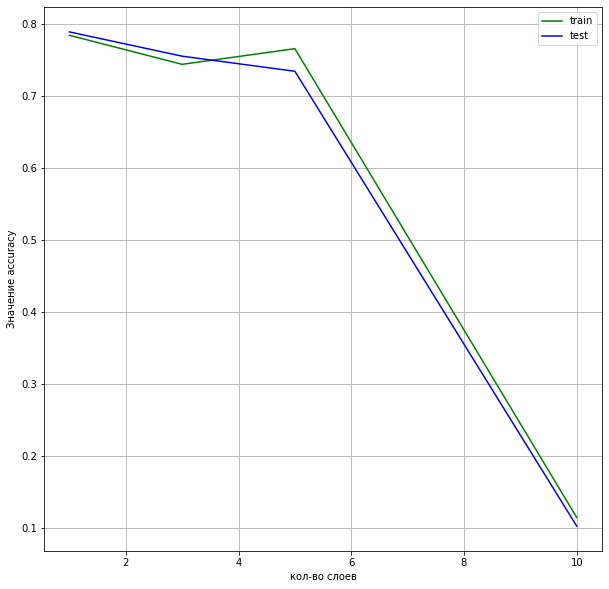

In [ ]:
c = [1,3,5,10]
train_cpu = [f.cpu() for f in train_accuracy]
test_cpu = [f.cpu() for f in test_accuracy]

plt.plot(c, train_cpu, "g")
plt.plot(c, test_cpu, "b")
plt.grid()
plt.ylabel("Значение accuracy")
plt.xlabel("кол-во слоев")
plt.rcParams["figure.figsize"] = (20, 20)
plt.legend(["train", "test"])


Заметно, что при увеличении кол-ва слоев модель начинала работать хуже, скорее всего, потому что, становилась слишком сложной для такой задачи

## 4. Бонусная часть.

### 4.1 Реализация метода оптимизации (3 + 3 балла).
Реализуйте сами метод оптимизации  для рассмотренной выше архитектуры. Вы можете выбрать произвольный метод от градиентного спуска до современных вариантов. Продемонстрируйте правильную работу метода оптимизации, сравните его работы с Adam. 

**Дополнительные баллы** вы получите, если метод будет уникален среди сдавших задание. 

In [ ]:
class SotaOptimizer(Optimizer):
    def __init__(self, params, lr=1e-3):
        defaults = dict(lr=lr)
        super(SotaOptimizer, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SotaOptimizer, self).__setstate__(state)

    @torch.no_grad()
    def step(self,):

        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:
                if p.grad is not None:
                    p.data.add_(-lr*p.grad)

### 4.2 Реализация современной функции активации (2 + 2 балла).
Реализуйте одну из активаций, предложенных на лекции или в статье. Например, `Hardswish`. Сравните сеть с вашей активацией и с `ReLU`. 

**Дополнительные баллы** вы получите, если функция будет уникальна среди сдавших задание. 

In [43]:

class SwishFunction(Function):
    @staticmethod
    def forward(ctx, inp, alpha):
        sigmoided = 1/(1+torch.exp(-inp))
        alpha = torch.tensor(alpha)
        ctx.save_for_backward(inp, alpha, sigmoided)
        return inp * alpha*sigmoided

    @staticmethod
    def backward(ctx, grad_output):
        inp, alpha, sigmoided = ctx.saved_tensors
        grad_inp = alpha*sigmoided + inp*alpha*(sigmoided*(1 -sigmoided))

        return grad_inp * grad_output, None
    

class Swish(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha
        

    def forward(self, inp):
        self.swish = SwishFunction.apply(inp , self.alpha)
        return self.swish

In [44]:
x = torch.tensor([[1,2,3],
                 [-1,2, 1]],dtype=torch.double,requires_grad=True)
relu = Swish(0.1)
assert gradcheck(relu, x)

In [45]:
x = torch.tensor([[1,2,3],
                 [-1,2, 1]],dtype=torch.double,requires_grad=False)

torch_relu = nn.SiLU()
our_relu = Swish(1)
print(torch_relu(x))
print(our_relu(x))
assert torch.norm(torch_relu(x.float()) - our_relu(x)) < 1e-5

tensor([[ 0.7311,  1.7616,  2.8577],
        [-0.2689,  1.7616,  0.7311]], dtype=torch.float64)
tensor([[ 0.7311,  1.7616,  2.8577],
        [-0.2689,  1.7616,  0.7311]], dtype=torch.float64)


In [46]:
class Network(nn.Module):
    def __init__(self, input_size=28*28, hidden_layers_size=32, num_layers=5,
                 num_classes=10):
        super().__init__()
        self.hid_block = []
        self.fc1 = Linear(28*28, 1024)
        self.swish = Swish(1)
        for i in range(num_layers):
            self.hid_block.append(Linear(1024, 1024))
            self.hid_block.append(Swish(1))
                                  
        self.hid_block = nn.Sequential(*self.hid_block)
        
        
        self.fc2 = Linear(1024, 512)
        self.swish2 = Swish(1)
        self.fc3 = Linear(512, 128)
        self.swish3 = Swish(1)
        self.fc4 = Linear(128, 64)
        self.swish5 = Swish(1)
        self.fc5 = Linear(64, 10)
        
        self.sf = LogSoftmax()

    def forward(self, inp):
        # inp = inp.to(torch.float32)
        # print(inp)
        x = self.fc1(inp)
        x = self.swish(x)
        x = self.hid_block(x)
        x = self.fc2(x)
        x = self.swish2(x)
        x = self.fc3(x)
        x = self.swish3(x)
        x = self.fc4(x)
        x = self.swish5(x)
        x = self.fc5(x)
        x = self.sf(x)

        
        return x
        
    def predict(self, inp):

        x = self.fc1(inp)
        x = self.swish(x)

        x = self.hid_block(x)
        
        x = self.fc2(x)
        x = self.swish2(x)
        x = self.fc3(x)
        x = self.swish3(x)
        x = self.fc4(x)
        x = self.swish5(x)
        x = self.fc5(x)
        
        _, preds  = torch.max(x.data, 1)
        return preds


In [47]:
model = Network()
optimizer = Adam(
    [
    {"params":model.parameters(), "lr":0.001}
    ],
)
criterion = CrossEntropy()


In [48]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in tqdm(range(10)):
    loss, acc, model = perform_epoch(model, train_dataloader, criterion, 
                                optimizer=optimizer, device=device)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

 10%|█         | 1/10 [01:37<14:35, 97.28s/it]

Epoch - 0 : loss 61260605750395.52, accuracy 0.7453978657722473
Current learning rate: 0.001


 20%|██        | 2/10 [03:11<12:43, 95.45s/it]

Epoch - 1 : loss 4913998877569.517, accuracy 0.7758685350418091
Current learning rate: 0.001


 30%|███       | 3/10 [04:47<11:09, 95.61s/it]

Epoch - 2 : loss 1173328118399.0312, accuracy 0.769083559513092
Current learning rate: 0.001


 40%|████      | 4/10 [06:23<09:35, 95.99s/it]

Epoch - 3 : loss 302866793112.26685, accuracy 0.7448645830154419
Current learning rate: 0.001


 50%|█████     | 5/10 [07:59<07:59, 95.97s/it]

Epoch - 4 : loss 136113681520.36995, accuracy 0.7284135818481445
Current learning rate: 0.001


 60%|██████    | 6/10 [09:37<06:26, 96.58s/it]

Epoch - 5 : loss 61996377318.03156, accuracy 0.7160969376564026
Current learning rate: 0.001


 70%|███████   | 7/10 [11:13<04:49, 96.46s/it]

Epoch - 6 : loss 31101205066.57156, accuracy 0.7154967784881592
Current learning rate: 0.001


 80%|████████  | 8/10 [12:51<03:13, 96.76s/it]

Epoch - 7 : loss 20589202920.43689, accuracy 0.7010772824287415
Current learning rate: 0.001


 90%|█████████ | 9/10 [14:27<01:36, 96.77s/it]

Epoch - 8 : loss 11358065102.601631, accuracy 0.6894100904464722
Current learning rate: 0.001


100%|██████████| 10/10 [16:05<00:00, 96.57s/it]

Epoch - 9 : loss 12534239782.85254, accuracy 0.6781094074249268
Current learning rate: 0.001


In [49]:
print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 9 : loss 12534239782.85254, accuracy 0.6781094074249268
Current learning rate: 0.001


In [50]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)


loss, acc, model = perform_epoch(model, test_dataloader, criterion, 
                            optimizer=None, device=device)
print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 9 : loss 10294097370.041733, accuracy 0.636831521987915
Current learning rate: 0.001



Заметно, что модель стала работать хуже с Swish-функцией активацией, возможно это связано с тем, что модель недостаточно глубокая